In [1]:
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
tf.config.list_physical_devices('GPU')

[]

In [2]:
tf.executing_eagerly()

True

## Load Dataset

In [3]:
(train_imgs,train_labels),(test_imgs,test_labels) = tf.keras.datasets.mnist.load_data(path="D:/Datasets/mnist.npz")

BufferSize = train_imgs.shape[0]
BatchSize = 500

train_imgs = tf.expand_dims(train_imgs,-1)
train_imgs = train_imgs/255 * 2 -1
trainloader = tf.data.Dataset.from_tensor_slices((train_imgs,train_labels)).shuffle(BufferSize).batch(BatchSize)
print(train_imgs.numpy().max(),   train_imgs.numpy().min(),train_imgs.shape )

1.0 -1.0 (60000, 28, 28, 1)


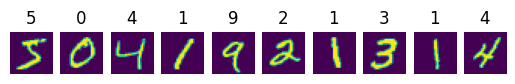

In [4]:
## View Img
def showBatchImg(images,labels,maxNum=5):
    fig, axes = plt.subplots(1, maxNum)
    for i in range(maxNum):
        axes[i].imshow(images[i].numpy().squeeze())
        axes[i].set_title(labels[i].item())
        axes[i].axis('off')
    plt.show()

showBatchImg(train_imgs, train_labels, 10)

## cGAN Model

Generator:  [noise+label] ==> Fake_Img  

Discriminator:  [Img + label] ==> if Real_Class ?

Loss: BCE(if Real&ClassMatch)


In [5]:
noise_len = 50

def Generator():  ## or: 3*3*128==>7*7*64==>14*14*32==>28*28*1
    seed = layers.Input(shape=(noise_len,))
    label = layers.Input(shape=((1,)))
    
    Embd = layers.Embedding(1,noise_len*2)(label)             
    Embd = layers.Reshape((noise_len*2,))(Embd)
    x = layers.concatenate([seed,Embd])                           ## B*150
    x = keras.Sequential(
    [
        layers.Dense(3*3*128,use_bias = False),                     ##  B*? ==> B*-
        layers.Reshape((3,3,128)),                                   ##      ==> B*3*3*128
        layers.BatchNormalization(), 
        layers.ReLU(),
        layers.Conv2DTranspose(64, 3, 2, use_bias=False),            ##      ==> B*7*7*64      ##  filters, kernel_size, strides
        layers.BatchNormalization(),                                                            ## = *strides + max(0,kernel_size-strides)
        layers.ReLU(),
        layers.Conv2DTranspose(32, 3, 2, padding="same", use_bias=False), ## ==> B*14*14*32     
        layers.BatchNormalization(), 
        layers.ReLU(),
        layers.Conv2DTranspose(1, 3, 2, padding="same", use_bias=False),  ## ==> B*28*28*1
        layers.Activation('tanh')    ## [-1,1]
    ])(x)
    GModel = tf.keras.Model(inputs=[seed,label],outputs=x)
    return GModel

def Discriminator():
    label = layers.Input(shape=((1,)))
    img = layers.Input(shape=(28,28,1))

    Embd = layers.Embedding(1,28*28)(label)
    Embd = layers.Reshape((28,28,1))(Embd)
    x = layers.concatenate([img,Embd])                        ## B*28*28*2
    x = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3),strides=(2, 2), padding="same", use_bias=False),    ##  ==> B*14*14*32
        layers.BatchNormalization(), 
        layers.LeakyReLU(),
        layers.Dropout(0.5), 
        layers.Conv2D(64, (3, 3),strides=(2, 2), padding="same", use_bias=False),    ##  ==> B*7*7*64
        layers.BatchNormalization(), 
        layers.LeakyReLU(),
        layers.Dropout(0.5),  
        layers.Flatten(),                                                            ##  ==> B*3136
        layers.Dense(1)                                                              ## logits: 未被 Activation 处理
    ])(x)
    
    DModel = tf.keras.Model(inputs=[img,label],outputs=x)
    return DModel


DModel = Discriminator()
GModel = Generator()

# ## Call Model ##############################
# img = tf.ones((2, 28,28,1))
# seed = tf.ones((2, noise_len))
# label = tf.ones((2, 1))

# DModel((img,label)).shape
# GModel((seed,label)).shape

Epoch 1----Generator Loss:: 0.429092----Discriminator Loss:: 2.092557


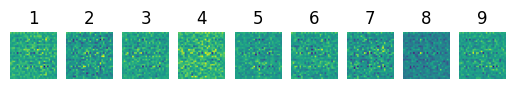

Epoch 2----Generator Loss:: 0.334640----Discriminator Loss:: 2.260359
Epoch 3----Generator Loss:: 0.326090----Discriminator Loss:: 2.344649
Epoch 4----Generator Loss:: 0.341251----Discriminator Loss:: 2.336335
Epoch 5----Generator Loss:: 0.359829----Discriminator Loss:: 2.288278
Epoch 6----Generator Loss:: 0.337864----Discriminator Loss:: 2.377474


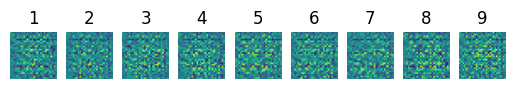

Epoch 7----Generator Loss:: 0.316332----Discriminator Loss:: 2.460815
Epoch 8----Generator Loss:: 0.295949----Discriminator Loss:: 2.575858
Epoch 9----Generator Loss:: 0.281291----Discriminator Loss:: 2.608733
Epoch 10----Generator Loss:: 0.294620----Discriminator Loss:: 2.608220
Epoch 11----Generator Loss:: 0.295162----Discriminator Loss:: 2.676584


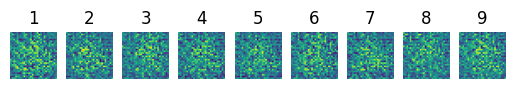

Epoch 12----Generator Loss:: 0.282229----Discriminator Loss:: 2.654958
Epoch 13----Generator Loss:: 0.311239----Discriminator Loss:: 2.592151
Epoch 14----Generator Loss:: 0.354152----Discriminator Loss:: 2.539623
Epoch 15----Generator Loss:: 0.348137----Discriminator Loss:: 2.600106
Epoch 16----Generator Loss:: 0.406491----Discriminator Loss:: 2.406168


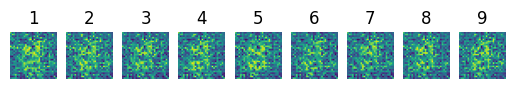

Epoch 17----Generator Loss:: 0.423511----Discriminator Loss:: 2.392576
Epoch 18----Generator Loss:: 0.463264----Discriminator Loss:: 2.356987
Epoch 19----Generator Loss:: 0.448540----Discriminator Loss:: 2.318107
Epoch 20----Generator Loss:: 0.442778----Discriminator Loss:: 2.346855
Epoch 21----Generator Loss:: 0.485796----Discriminator Loss:: 2.244649


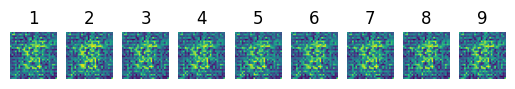

Epoch 22----Generator Loss:: 0.525231----Discriminator Loss:: 2.239948
Epoch 23----Generator Loss:: 0.487250----Discriminator Loss:: 2.330833
Epoch 24----Generator Loss:: 0.455079----Discriminator Loss:: 2.408797
Epoch 25----Generator Loss:: 0.526424----Discriminator Loss:: 2.298926
Epoch 26----Generator Loss:: 0.563957----Discriminator Loss:: 2.327412


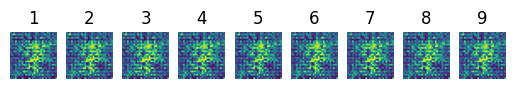

Epoch 27----Generator Loss:: 0.531858----Discriminator Loss:: 2.259984
Epoch 28----Generator Loss:: 0.574550----Discriminator Loss:: 2.255629
Epoch 29----Generator Loss:: 0.642169----Discriminator Loss:: 2.151730
Epoch 30----Generator Loss:: 0.659532----Discriminator Loss:: 2.186303


In [6]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optG = tf.keras.optimizers.Adam(1e-5)
optD = tf.keras.optimizers.Adam(1e-5)

def lossDfn(predR,predF):
    lossR = bce(tf.ones_like(predR),predR)
    lossF = bce(tf.zeros_like(predF),predF)
    return lossR+lossF

def lossGfn(predF):
    return bce(tf.ones_like(predF),predF)

# @tf.function   ## 快速但复杂。。此处如果加上则step3开始不计算GradientTape了
def trainStep(Images,Labels,DModel, GModel, trainD = True):
    Seeds = tf.random.normal([Labels.shape[0],noise_len])
    with tf.GradientTape() as tapeG, tf.GradientTape() as tapeD:
        FakeImgs = GModel((Seeds,Labels),training=True)
        predF = DModel((FakeImgs,Labels),training=trainD)
        predR = DModel((Images,Labels),training=trainD)
        lossG = lossGfn(predF)
        lossD = lossDfn(predR,predF)
    gradG = tapeG.gradient(lossG,GModel.trainable_variables) 
    optG.apply_gradients(zip(gradG,GModel.trainable_variables))
    if trainD:
        gradD = tapeD.gradient(lossD,DModel.trainable_variables)
        optD.apply_gradients(zip(gradD,DModel.trainable_variables))
    return lossG,lossD

## Show Fakes
def Use_Model(label_arr):
    testseed =tf.random.normal([label_arr.shape[0],noise_len])
    FakeImgs = GModel((testseed,tf.convert_to_tensor(label_arr)),training=False)
    showBatchImg(FakeImgs, label_arr,maxNum=label_arr.shape[0])

for epoch in range(30):
    counter = 0
    for _ , (Images,Labels) in enumerate(trainloader):
        tmplossG,tmplossD = trainStep(Images,Labels,DModel, GModel, trainD = (counter%3 == 0))   ## not train D once by every x steps
        counter += 1
        if counter%100 == 0:
            print(f'Epoch {epoch+1}----Generator Loss:: {tmplossG:>7f}----Discriminator Loss:: {tmplossD:>7f}')
    if epoch%5 == 0:
        Use_Model(np.array([1,2,3,4,5,6,7,8,9]))

In [7]:
## Q：如何进行G与D的强弱平衡啊。。。是否应该先用其它task预训练一下
## @tf.function 图执行模式下 一定要确认 GradientTape 是不是被计算